In [27]:
import numpy as np
import xarray as xr
import pandas as pd
import thermo
import matplotlib.pyplot as plt
from cycler import cycler
import plume_ascent

%matplotlib inline

In [42]:
# Plume parameters for all fires
a_w = 1
b_w = 0.1
fac_ent=0.0025
beta = 0.75

Text(0.5, 0, 'Liquid water [kg/kg]')

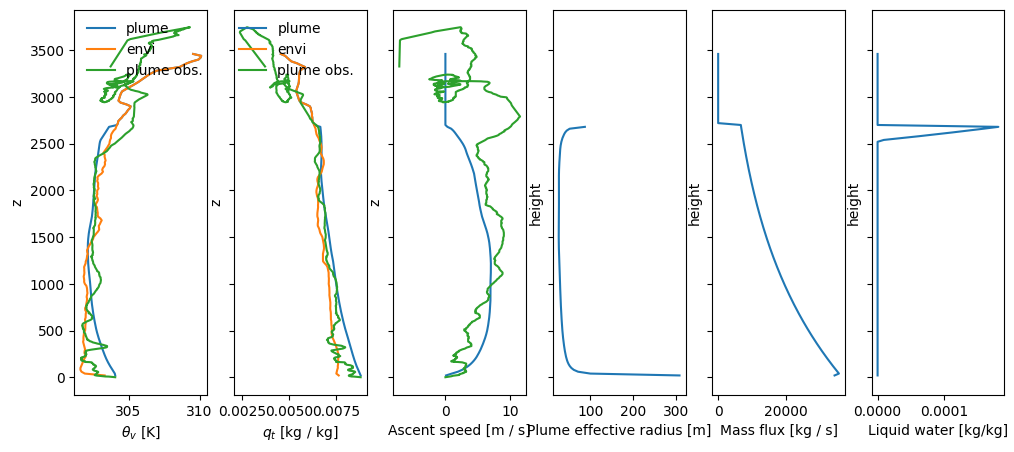

In [46]:
fire = 'Martorell_2021-07-13'

# Initialise environment
# Load env from sounding
ds_sou_e = (pd.read_csv('radiosondes/'+fire+'/env_sounding/env.csv',
                        header=1,
                        index_col='Height (m AGL)')
                       .to_xarray()
                       .rename({'Height (m AGL)':'z',
                                ' Pressure (mb)':'p',
                                ' Temperature (C)':'T',
                                ' Relative humidity (%)':'rh'}))
h_0 = ds_sou_e['z'][0].data
height = ds_sou_e['z'].data

# Conversions
pres_e = (ds_sou_e['p'] * 100).data # hPa -> Pa conversion
T_e = (ds_sou_e['T'] + 273.15).data # C -> K conversion
rh_e = (ds_sou_e['rh'] / 100).data # % -> fraction conversion
q_t_e = rh_e * thermo.qsatur(T_e, pres_e)
theta_l_e = thermo.calculate_theta(T_e, pres_e)

# Load in-plume sounding
ds_sou_p = (pd.read_csv('radiosondes/'+fire+'/plume_sounding/plume.csv',
                            index_col=' Altitude (m AGL)')
                           .to_xarray()
                           .rename({' Altitude (m AGL)':'z',
                                    ' Pressure (Pascal)':'p',
                                    ' Temperature (C)':'T',
                                    ' Relative humidity (%)':'rh',
                                    ' Rise speed (m/s)':'w'}))

ds_sou_p['pres_p'] = ds_sou_p['p']
ds_sou_p['T_p'] = ds_sou_p['T'] + 273.15 # C -> K conversion
ds_sou_p['rh_p'] = ds_sou_p['rh'] / 100 # % -> fraction conversion
ds_sou_p['q_t_p'] = ds_sou_p['rh_p'] * thermo.qsatur(ds_sou_p['T_p'], ds_sou_p['pres_p'])
ds_sou_p['theta_l_p'] = thermo.calculate_theta(ds_sou_p['T_p'], ds_sou_p['pres_p']) # < if the plume is unsaturated!!

ds_sou_p['q_l_p'] = ds_sou_p['rh_p'].copy()
ds_sou_p['theta_p'] = ds_sou_p['rh_p'].copy()
ds_sou_p['theta_v_p'] = ds_sou_p['rh_p'].copy()
for i in range(ds_sou_p['z'].size):
    ds_sou_p['T_p'][i], ds_sou_p['q_l_p'][i], ds_sou_p['theta_p'][i], ds_sou_p['theta_v_p'][i] = thermo.calculate_thermo(ds_sou_p['theta_l_p'][i], ds_sou_p['q_t_p'][i], ds_sou_p['pres_p'][i])

# Fire parameters (guesses)
w_p_0 = 0.1 # m/s
l_fire = 1000 # m, assumed fire length scale
d_fire = 300 # m
S_fire = l_fire * d_fire

theta_l_p_0 = ds_sou_p['theta_l_p'][0]
q_t_p_0 = ds_sou_p['q_t_p'][0]

# Release plume
ds = plume_ascent.plume_ascent(theta_l_e, q_t_e, pres_e, height, theta_l_p_0, q_t_p_0, S_fire, w_p_0,
                               a_w = a_w, b_w = b_w, fac_ent=fac_ent, beta = beta)

# Plot
zmax = 3500

fig, axs = plt.subplots(ncols=6, figsize=(12,5), sharey=True)
ds['theta_v_p'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='plume')
ds['theta_v_e'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='envi')
ds_sou_p['theta_v_p'].plot(y='z', ax=axs[0],label='plume obs.')
axs[0].legend(bbox_to_anchor=(0,1), loc='upper left', frameon=False)
axs[0].set_xlabel(r'$\theta_v$ [K]')

(ds['q_t_p']).sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='plume')
(ds['q_t_e']).sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='envi')
ds_sou_p['q_t_p'].plot(y='z', ax=axs[1], label='plume obs.')
axs[1].legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)
axs[1].set_xlabel('$q_t$ [kg / kg]')

(ds['w_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[2])
ds_sou_p['w'].plot(y='z', ax=axs[2], c='C2')
axs[2].set_xlabel('Ascent speed [m / s]')
    
(np.sqrt(ds['a_p'] / np.pi)).sel(height=slice(0,zmax)).plot(y='height', ax=axs[3])
axs[3].set_xlabel('Plume effective radius [m]')

ds['mass_flux_p'].sel(height=slice(0,zmax)).plot(y='height', ax=axs[4])
axs[4].set_xlabel('Mass flux [kg / s]')

(ds['q_l_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[5])
axs[5].set_xlabel('Liquid water [kg/kg]')

Text(0.5, 0, 'Liquid water [kg/kg]')

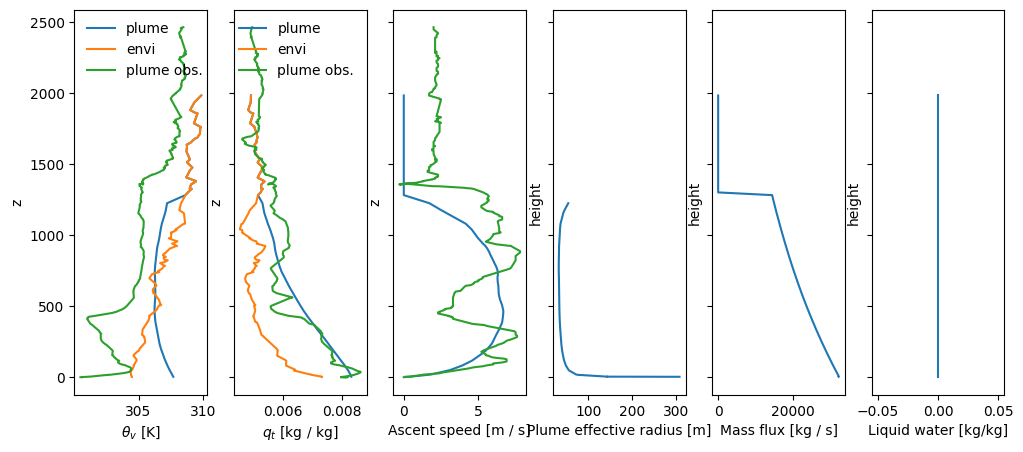

In [47]:
fire = 'batea'

# Initialise environment
# Load environment from sounding
ds_sou_e = (pd.read_csv('radiosondes/'+fire+'/env_sounding/env.csv',
                        index_col='agl')
                       .to_xarray()
                       .rename({'agl':'z',
                                'pressure':'p', # Pa
                                'temperature':'T', # C
                                'relative_humidity':'rh'}
           ))
ds_sou_e = ds_sou_e.where(ds_sou_e.z>0, drop=True)

h_0 = ds_sou_e['z'][0].data
height = ds_sou_e['z'].data

# Conversions
pres_e = ds_sou_e['p'].data
T_e = (ds_sou_e['T'] + 273.15).data # C -> K conversion
rh_e = (ds_sou_e['rh'] / 100).data # % -> fraction conversion
q_t_e = rh_e * thermo.qsatur(T_e, pres_e)
theta_l_e = thermo.calculate_theta(T_e, pres_e)

# Load in-plume sounding
ds_sou_p = (pd.read_csv('radiosondes/'+fire+'/plume_sounding/plume.csv',
                            index_col='agl')
                           .to_xarray()
                           .rename({'agl':'z',
                                'pressure':'p', # Pa
                                'temperature':'T', # C
                                'relative_humidity':'rh',
                                'rise_speed':'w'}
           ))

ds_sou_p['pres_p'] = ds_sou_p['p']
ds_sou_p['T_p'] = ds_sou_p['T'] + 273.15 # C -> K conversion
ds_sou_p['rh_p'] = ds_sou_p['rh'] / 100 # % -> fraction conversion
ds_sou_p['q_t_p'] = ds_sou_p['rh_p'] * thermo.qsatur(ds_sou_p['T_p'], ds_sou_p['pres_p'])
ds_sou_p['theta_l_p'] = thermo.calculate_theta(ds_sou_p['T_p'], ds_sou_p['pres_p']) # < if the plume is unsaturated!!

ds_sou_p['q_l_p'] = ds_sou_p['rh_p'].copy()
ds_sou_p['theta_p'] = ds_sou_p['rh_p'].copy()
ds_sou_p['theta_v_p'] = ds_sou_p['rh_p'].copy()
for i in range(ds_sou_p['z'].size):
    ds_sou_p['T_p'][i], ds_sou_p['q_l_p'][i], ds_sou_p['theta_p'][i], ds_sou_p['theta_v_p'][i] = thermo.calculate_thermo(ds_sou_p['theta_l_p'][i], ds_sou_p['q_t_p'][i], ds_sou_p['pres_p'][i])

# Initialise surface with variables from in-plume soundings, just for validating the ascent
w_p_0 = 0.1 # m/s
l_fire = 1000 # m, assumed fire length scale
d_fire = 300 # m
S_fire = l_fire * d_fire

# Add excess temperature and moisture to the first model level of the plume
theta_l_p_0 = theta_l_e[0]+3
q_t_p_0 = q_t_e[0]+0.001

# Ascent
ds = plume_ascent.plume_ascent(theta_l_e, q_t_e, pres_e, height, theta_l_p_0, q_t_p_0, S_fire, w_p_0,
                               a_w = a_w, b_w = b_w, fac_ent=fac_ent, beta = beta)

# Plot
zmax=2000

fig, axs = plt.subplots(ncols=6, figsize=(12,5), sharey=True)
ds['theta_v_p'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='plume')
ds['theta_v_e'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='envi')
ds_sou_p['theta_v_p'].plot(y='z', ax=axs[0],label='plume obs.')
axs[0].legend(bbox_to_anchor=(0,1), loc='upper left', frameon=False)
axs[0].set_xlabel(r'$\theta_v$ [K]')

(ds['q_t_p']).sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='plume')
(ds['q_t_e']).sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='envi')
ds_sou_p['q_t_p'].plot(y='z', ax=axs[1], label='plume obs.')
axs[1].legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)
axs[1].set_xlabel('$q_t$ [kg / kg]')

(ds['w_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[2])
ds_sou_p['w'].plot(y='z', ax=axs[2], c='C2')
axs[2].set_xlabel('Ascent speed [m / s]')
    
(np.sqrt(ds['a_p'] / np.pi)).sel(height=slice(0,zmax)).plot(y='height', ax=axs[3])
axs[3].set_xlabel('Plume effective radius [m]')

ds['mass_flux_p'].sel(height=slice(0,zmax)).plot(y='height', ax=axs[4])
axs[4].set_xlabel('Mass flux [kg / s]')

(ds['q_l_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[5])
axs[5].set_xlabel('Liquid water [kg/kg]')

(0.0, 2000.0)

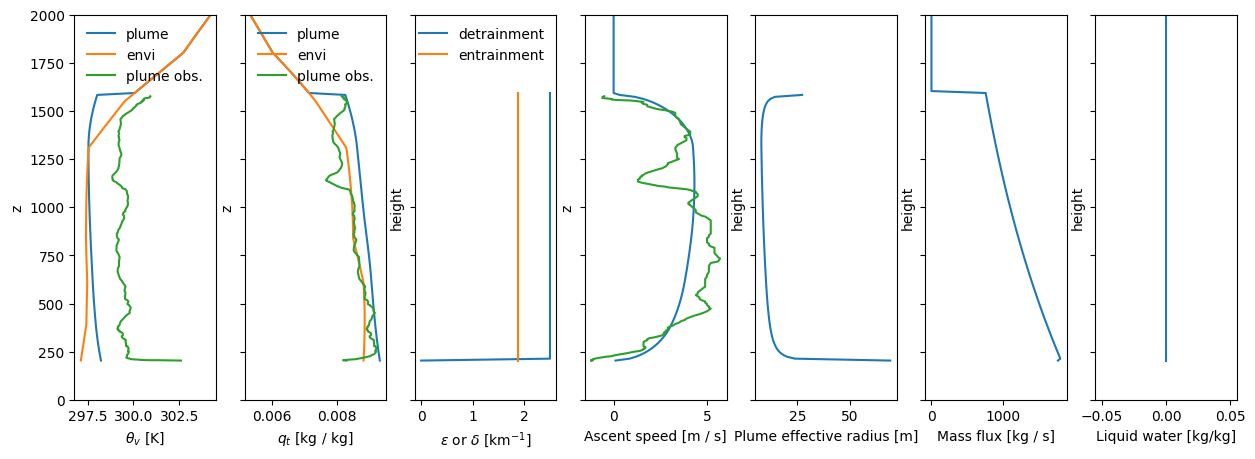

In [56]:
fire = 'tortosa'

# Initialise environment
# Load environment from era5
ds_sou_e = xr.open_dataset('radiosondes/'+fire+'/env_sounding/env.nc').isel(valid_time=1,latitude=0,longitude=0)
ds_sou_e['zm'] = ds_sou_e['z']/9.81
ds_sou_e = ds_sou_e.set_coords(['zm']).swap_dims({'pressure_level':'zm'})

# Interpolate to finer grid for plume release
h_0 = 204 # where in the environmental sounding (which is assumed to be above mean sea level) we should start
height = np.arange(h_0, 5010, 10)
ds_sou_e = ds_sou_e.interp(zm=height)

# Conversions
pres_e = (ds_sou_e['pressure_level'].data)*100 # hPa -> Pa
T_e = ds_sou_e['t'].data
rh_e = (ds_sou_e['r'] / 100).data # % -> fraction conversion
q_t_e = rh_e * thermo.qsatur(T_e, pres_e)
theta_l_e = thermo.calculate_theta(T_e, pres_e)

# Load in-plume sounding
ds_sou_p = (pd.read_csv('radiosondes/'+fire+'/plume_sounding/plume.csv',
                            index_col='agl')
                           .to_xarray()
                           .rename({'agl':'z',
                                    'pressure':'p', # Pa
                                    'temperature':'T', # C
                                    'relative_humidity':'rh',
                                    'rise_speed':'w'}
                                   )
                            .isel(z=slice(2,220))
           )
# NOTE
# In this raw sounding data, agl is probably above sea level:
# https://www.google.co.uk/maps/place/40%C2%B049'24.9%22N+0%C2%B035'36.5%22E/@40.82253,0.5850122,15.58z/data=!4m4!3m3!8m2!3d40.82357!4d0.59346!5m1!1e4?entry=ttu&g_ep=EgoyMDI1MDUxNS4xIKXMDSoASAFQAw%3D%3D
# So we use agl as if it were wrt sea level

ds_sou_p['pres_p'] = ds_sou_p['p']
ds_sou_p['T_p'] = ds_sou_p['T'] + 273.15 # C -> K conversion
ds_sou_p['rh_p'] = ds_sou_p['rh'] / 100 # % -> fraction conversion
ds_sou_p['q_t_p'] = ds_sou_p['rh_p'] * thermo.qsatur(ds_sou_p['T_p'], ds_sou_p['pres_p'])
ds_sou_p['theta_l_p'] = thermo.calculate_theta(ds_sou_p['T_p'], ds_sou_p['pres_p']) # < if the plume is unsaturated!!

ds_sou_p['q_l_p'] = ds_sou_p['rh_p'].copy()
ds_sou_p['theta_p'] = ds_sou_p['rh_p'].copy()
ds_sou_p['theta_v_p'] = ds_sou_p['rh_p'].copy()
for i in range(ds_sou_p['z'].size):
    ds_sou_p['T_p'][i], ds_sou_p['q_l_p'][i], ds_sou_p['theta_p'][i], ds_sou_p['theta_v_p'][i] = thermo.calculate_thermo(ds_sou_p['theta_l_p'][i], ds_sou_p['q_t_p'][i], ds_sou_p['pres_p'][i])

# Initialise surface with variables from in-plume soundings, just for validating the ascent
w_p_0 = 0.1 # m/s
l_fire = 500 # m, assumed fire length scale
d_fire = 30 # m
S_fire = l_fire * d_fire

# Add excess temperature and moisture to the first model level of the plume
theta_l_p_0 = theta_l_e[0]+1
q_t_p_0 = q_t_e[0]+0.0005

# Ascent
ds = plume_ascent.plume_ascent(theta_l_e, q_t_e, pres_e, height, theta_l_p_0, q_t_p_0, S_fire, w_p_0,
                               a_w = a_w, b_w = b_w, fac_ent=fac_ent, beta = beta)

# Plot
zmax=2000
fig, axs = plt.subplots(ncols=7, figsize=(15,5), sharey=True)
ds['theta_v_p'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='plume')
ds['theta_v_e'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='envi')
ds_sou_p['theta_v_p'].plot(y='z', ax=axs[0],label='plume obs.')
axs[0].legend(bbox_to_anchor=(0,1), loc='upper left', frameon=False)
axs[0].set_xlabel(r'$\theta_v$ [K]')

(ds['q_t_p']).sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='plume')
(ds['q_t_e']).sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='envi')
ds_sou_p['q_t_p'].plot(y='z', ax=axs[1], label='plume obs.')
axs[1].legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)
axs[1].set_xlabel('$q_t$ [kg / kg]')

(ds['detrainment']/ds['mass_flux_p']*1000).sel(height=slice(0,zmax)).plot(y='height', ax=axs[2], label='detrainment')
(ds['entrainment']/ds['mass_flux_p']*1000).sel(height=slice(0,zmax)).plot(y='height', ax=axs[2], label='entrainment')
axs[2].legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)
axs[2].set_xlabel(r'$\varepsilon$ or $\delta$ [km$^{-1}$]')

(ds['w_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[3])
(ds_sou_p['w'] - 2).plot(y='z', ax=axs[3], c='C2')
axs[3].set_xlabel('Ascent speed [m / s]')
    
(np.sqrt(ds['a_p'] / np.pi)).sel(height=slice(0,zmax)).plot(y='height', ax=axs[4])
axs[4].set_xlabel('Plume effective radius [m]')

ds['mass_flux_p'].sel(height=slice(0,zmax)).plot(y='height', ax=axs[5])
axs[5].set_xlabel('Mass flux [kg / s]')

(ds['q_l_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[6])
axs[6].set_xlabel('Liquid water [kg/kg]')

axs[0].set_ylim(0,zmax)

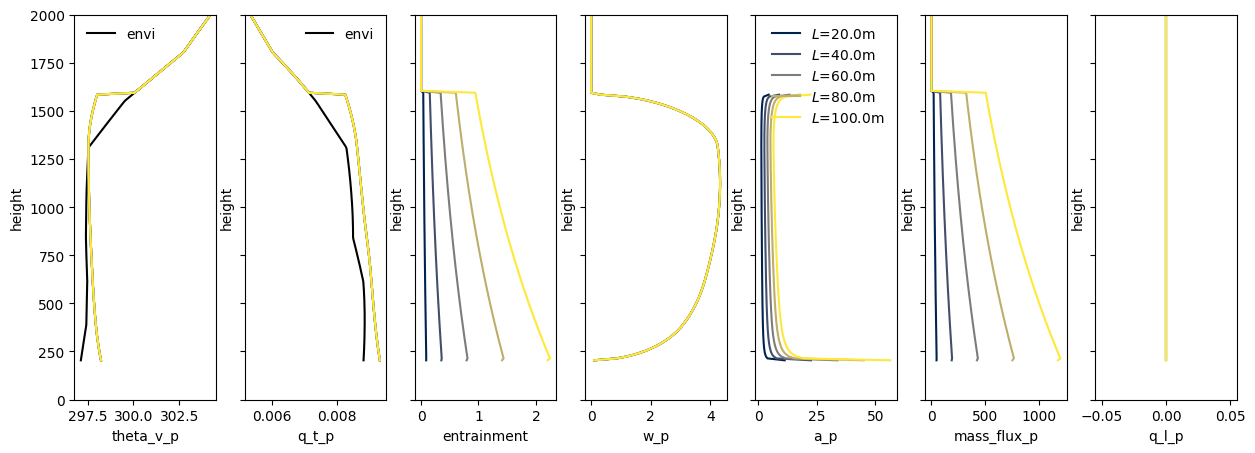

In [49]:
# Test the Tortosa env for range of S_fire
# Must have run the original plume first to get complete envs

S_fire = np.arange(20,120,20)**2

# Plot env
zmax=2000
fig, axs = plt.subplots(ncols=7, figsize=(15,5), sharey=True)
ds['theta_v_e'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='envi', c='k')
axs[0].legend(bbox_to_anchor=(0,1), loc='upper left', frameon=False)
axs[0].set_xlabel(r'$\theta_v$ [K]')
(ds['q_t_e']).sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='envi', c='k')
axs[1].legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)
axs[1].set_xlabel('$q_t$ [kg / kg]')
axs[2].set_xlabel(r'e or d [km$^{-1}$]')
# (ds_sou_p['w'] - 2).plot(y='z', ax=axs[3], c='C2')
axs[3].set_xlabel('Ascent speed [m / s]')
axs[4].set_xlabel('Plume effective radius [m]')
axs[5].set_xlabel('Mass flux [kg / s]')
axs[6].set_xlabel('Liquid water [kg/kg]')
axs[0].set_ylim(0,zmax)
for ax in axs:
    ax.set_prop_cycle(cycler(color=plt.cm.cividis(np.linspace(0, 1, len(S_fire)))))

# Now fractional entrainment is independent of S_fire, so vertical velocity should be unaffected
# So mass flux reductions with altitude go more rapidly (dM/dz = eps*M and M=rho*w*S_fire)
# But this is covered by more rapid area reductions
# Plume tops are unaffected.

for i in range(len(S_fire)):
    ds = plume_ascent.plume_ascent(theta_l_e, q_t_e, pres_e, height, theta_l_p_0, q_t_p_0, S_fire[i], w_p_0,
                                   a_w = a_w, b_w = b_w, fac_ent=fac_ent, beta = beta)
    
    ds['theta_v_p'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='plume')
    ds['q_t_p'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='plume')
    # (ds['detrainment']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[2], label='detrainment')
    (ds['entrainment']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[2], label='gross entrainment')
    (ds['w_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[3])
    (np.sqrt(ds['a_p'] / np.pi)).sel(height=slice(0,zmax)).plot(y='height', ax=axs[4],label=r'$L$='+str(np.round(np.sqrt(S_fire[i]),0))+'m')
    ds['mass_flux_p'].sel(height=slice(0,zmax)).plot(y='height', ax=axs[5])
    (ds['q_l_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[6])

axs[4].legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)


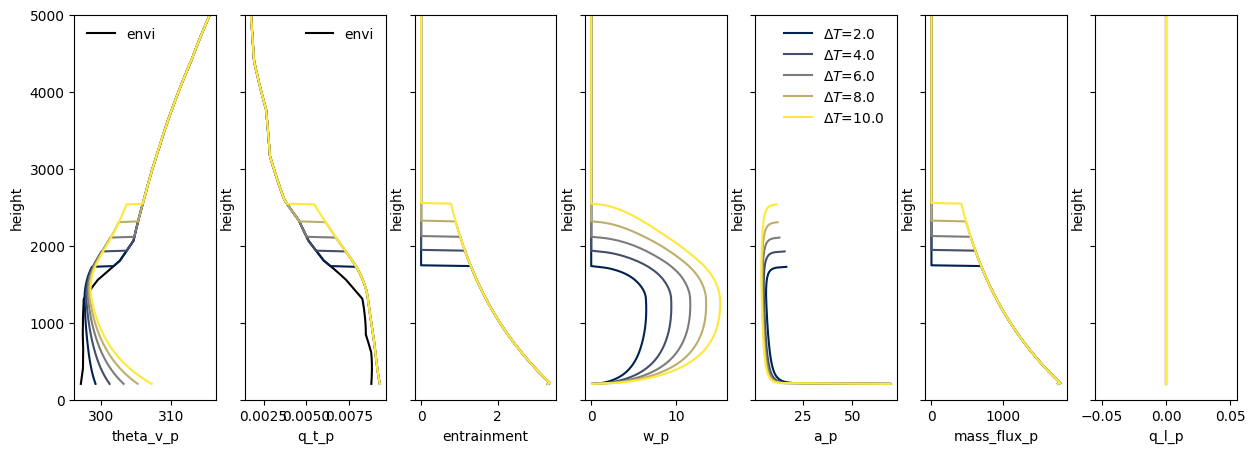

In [57]:
# Test the Tortosa env for range of initial d_T
# Must have run the original plume first to get complete envs
S_fire = l_fire*d_fire

theta_l_p_0 = theta_l_e[0]+np.arange(2,12,2)*(pres_e[0]/1e5)**(2./7)

# Plot env
zmax=5000
fig, axs = plt.subplots(ncols=7, figsize=(15,5), sharey=True)
ds['theta_v_e'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='envi', c='k')
axs[0].legend(bbox_to_anchor=(0,1), loc='upper left', frameon=False)
axs[0].set_xlabel(r'$\theta_v$ [K]')
(ds['q_t_e']).sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='envi', c='k')
axs[1].legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)
axs[1].set_xlabel('$q_t$ [kg / kg]')
axs[2].set_xlabel(r'e or d [km$^{-1}$]')
# (ds_sou_p['w'] - 2).plot(y='z', ax=axs[3], c='C2')
axs[3].set_xlabel('Ascent speed [m / s]')
axs[4].set_xlabel('Plume effective radius [m]')
axs[5].set_xlabel('Mass flux [kg / s]')
axs[6].set_xlabel('Liquid water [kg/kg]')
axs[0].set_ylim(0,zmax)
for ax in axs:
    ax.set_prop_cycle(cycler(color=plt.cm.cividis(np.linspace(0, 1, len(theta_l_p_0)))))

for i in range(len(theta_l_p_0)):
    ds = plume_ascent.plume_ascent(theta_l_e, q_t_e, pres_e, height, theta_l_p_0[i], q_t_p_0, S_fire, w_p_0,
                                   a_w = a_w, b_w = b_w, fac_ent=fac_ent, beta = beta)
    
    ds['theta_v_p'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='plume')
    ds['q_t_p'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='plume')
    # (ds['detrainment']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[2], label='detrainment')
    (ds['entrainment']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[2], label='gross entrainment')
    (ds['w_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[3])
    (np.sqrt(ds['a_p'] / np.pi)).sel(height=slice(0,zmax)).plot(y='height', ax=axs[4],label=r'$\Delta T$='+str(np.round(theta_l_p_0[i]-theta_l_e[0],0))+' K')
    ds['mass_flux_p'].sel(height=slice(0,zmax)).plot(y='height', ax=axs[5])
    (ds['q_l_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[6])

axs[4].legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)


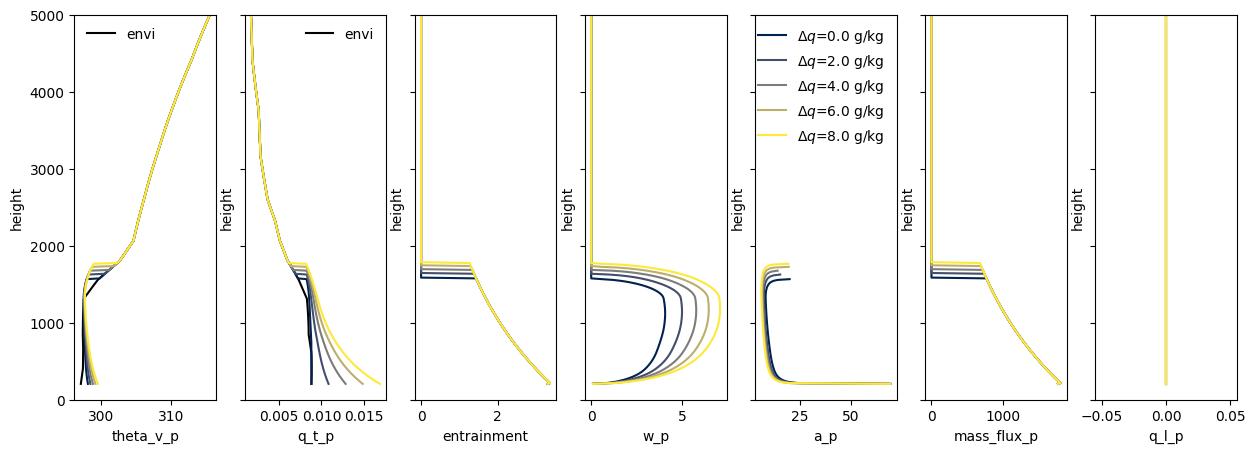

In [63]:
# Test the Tortosa env for range of initial d_q
# Must have run the original plume first to get complete envs
S_fire = l_fire*d_fire
theta_l_p_0 = theta_l_e[0]+1
q_t_p_0 = q_t_e[0] + np.arange(0.,0.01,0.002)

# Plot env
zmax=5000
fig, axs = plt.subplots(ncols=7, figsize=(15,5), sharey=True)
ds['theta_v_e'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='envi', c='k')
axs[0].legend(bbox_to_anchor=(0,1), loc='upper left', frameon=False)
axs[0].set_xlabel(r'$\theta_v$ [K]')
(ds['q_t_e']).sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='envi', c='k')
axs[1].legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)
axs[1].set_xlabel('$q_t$ [kg / kg]')
axs[2].set_xlabel(r'e or d [km$^{-1}$]')
# (ds_sou_p['w'] - 2).plot(y='z', ax=axs[3], c='C2')
axs[3].set_xlabel('Ascent speed [m / s]')
axs[4].set_xlabel('Plume effective radius [m]')
axs[5].set_xlabel('Mass flux [kg / s]')
axs[6].set_xlabel('Liquid water [kg/kg]')
axs[0].set_ylim(0,zmax)
for ax in axs:
    ax.set_prop_cycle(cycler(color=plt.cm.cividis(np.linspace(0, 1, len(q_t_p_0)))))

for i in range(len(q_t_p_0)):
    ds = plume_ascent.plume_ascent(theta_l_e, q_t_e, pres_e, height, theta_l_p_0, q_t_p_0[i], S_fire, w_p_0,
                                   a_w = a_w, b_w = b_w, fac_ent=fac_ent, beta = beta)
    
    ds['theta_v_p'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='plume')
    ds['q_t_p'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='plume')
    # (ds['detrainment']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[2], label='detrainment')
    (ds['entrainment']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[2], label='gross entrainment')
    (ds['w_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[3])
    (np.sqrt(ds['a_p'] / np.pi)).sel(height=slice(0,zmax)).plot(y='height', ax=axs[4],label=r'$\Delta q$='+str(np.round((q_t_p_0[i]-q_t_e[0])*1000,1))+' g/kg')
    ds['mass_flux_p'].sel(height=slice(0,zmax)).plot(y='height', ax=axs[5])
    (ds['q_l_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[6])

axs[4].legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)
